OMDB Transfer Learning for Bandgap Prediction
Using E_GAP_ALPHA pre-trained model with OPTUNA-OPTIMIZED hyperparameters
cuda:7
Using device: cuda:7
OMDB TRANSFER LEARNING PIPELINE

Step 1: Loading OMDB dataset
Loading OMDB dataset using pandas...
Dataset loaded successfully:
  Shape: (11368, 3)
  Columns: ['CODID', 'SMILE', 'bgs']
  Before cleaning: 11368 samples
  After cleaning: 11368 samples
  Number of molecules: 11368
  Bandgap range: 0.000 - 8.540 eV

Step 2: Loading pre-trained E_GAP_ALPHA model
Loading pre-trained E_GAP_ALPHA model...
Successfully loaded E_GAP_ALPHA model

Step 3: Preparing dataset using existing infrastructure
Preparing OMDB dataset using existing infrastructure...
Processed data already exists

Step 4: Creating data loaders
Creating data loaders from processed data...
Data loaders created:
  Train: 8403 samples
  Val: 1034 samples
  Test: 1035 samples

Dataset split summary:
  Train: 8403 samples
  Validation: 1034 samples
  Test: 1035 samples

Step 5: Settin

/home/arslan/anaconda3/envs/py39/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch   0: Train Loss: 0.5415, Val Loss: 0.3564
Epoch  10: Train Loss: 0.2012, Val Loss: 0.9193
Epoch  20: Train Loss: 0.1628, Val Loss: 0.1852
Epoch  30: Train Loss: 0.1329, Val Loss: 0.1527
Epoch  40: Train Loss: 0.1238, Val Loss: 0.1382
Epoch  50: Train Loss: 0.1148, Val Loss: 0.1306
Epoch  60: Train Loss: 0.0959, Val Loss: 0.1242
Epoch  70: Train Loss: 0.0893, Val Loss: 0.1279
Epoch  80: Train Loss: 0.0687, Val Loss: 0.1238
Epoch  90: Train Loss: 0.0602, Val Loss: 0.1243
Fine-tuning completed

Step 7: Evaluating model
Evaluating model...
Test Results:
  R² Score: 0.8733
  MAE: 0.2509 eV
  RMSE: 0.3575 eV

Step 8: Creating visualizations
Plot saved to results/omdb_transfer_learning_results.png


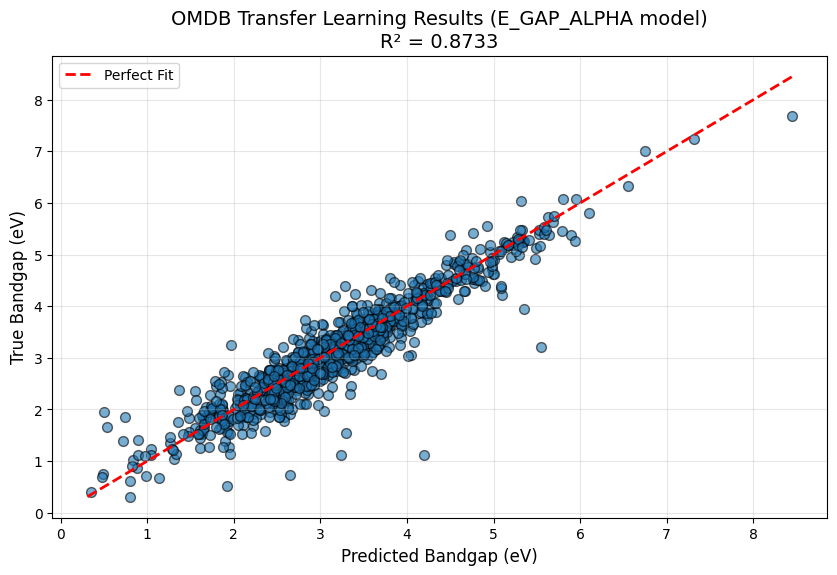


Step 9: Saving model
Transfer model saved to results/omdb_transfer_model.pth

Step 10: Saving results
Results saved to results/omdb_transfer_results.json
OMDB TRANSFER LEARNING COMPLETED

Transfer learning completed successfully!
Final R² Score: 0.8733
Final MAE: 0.2509 eV
Final RMSE: 0.3575 eV


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Transfer Learning for OMDB Dataset - Using Working Infrastructure
Fine-tuning E_GAP_ALPHA model for bandgap prediction

OPTUNA-OPTIMIZED HYPERPARAMETERS (Best Trial 222):
- Learning Rate: 0.0014405055346523139
- Unfreeze Layers: 7
- Dropout: 0.20522610537651914
- Weight Decay: 1.0498768080401706e-06
- Batch Size: 64


import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import os
import json
import csv

# Import pandas (this should work since it works in your notebook)
import pandas as pd

# Import your existing modules (avoiding pandas import issues)
from models.solubilityPredictor_resgatedgraphconvN import SolPredictor
from models.regression_train_test import train, test, predicting
from solubility.folds.datacreator import createFoldsCsv, createTestData
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from Data_Prep.Graph_Data import Molecule_data

class OMDBTransferLearning:
    """Transfer learning specifically for OMDB dataset using E_GAP_ALPHA model"""
    
    def __init__(self, device="cpu"):
        self.device = device
        self.source_model = None
        self.transfer_model = None
        
    def load_omdb_dataset_pandas(self, csv_path="Data_Prep/omdb_smile_data_set.csv"):
        """Load OMDB dataset using pandas (like the working notebook)"""
        print("Loading OMDB dataset using pandas...")
        
        if not os.path.exists(csv_path):
            print(f"Error: Dataset file not found at {csv_path}")
            return None
        
        try:
            # Load the CSV file using pandas (same as working notebook)
            df = pd.read_csv(csv_path)
            print(f"Dataset loaded successfully:")
            print(f"  Shape: {df.shape}")
            print(f"  Columns: {list(df.columns)}")
            
            # Check if required columns exist
            if 'SMILE' not in df.columns or 'bgs' not in df.columns:
                print("Error: Required columns 'SMILE' and 'bgs' not found!")
                print(f"Available columns: {list(df.columns)}")
                return None
            
            # Clean the data (same as working notebook)
            df = df.dropna(axis=1, how='all')
            df.dropna(subset=['SMILE'], inplace=True)
            
            # Check for valid SMILES and target values
            print(f"  Before cleaning: {len(df)} samples")
            
            # Filter out invalid SMILES or target values
            df = df[df['SMILE'].notna() & df['bgs'].notna()]
            df = df[df['SMILE'].str.strip() != '']
            
            # Convert target to numeric and filter out invalid values
            df['bgs'] = pd.to_numeric(df['bgs'], errors='coerce')
            df = df[df['bgs'].notna()]
            
            print(f"  After cleaning: {len(df)} samples")
            
            if len(df) < 10:
                print("Warning: Very small dataset! Only {} samples after cleaning.".format(len(df)))
                print("This might cause issues with training.")
            
            # Rename columns to match expected format
            df = df.rename(columns={'SMILE': 'SMILES_str', 'bgs': 'target'})
            
            print(f"  Number of molecules: {len(df)}")
            print(f"  Bandgap range: {df['target'].min():.3f} - {df['target'].max():.3f} eV")
            
            return df
            
        except Exception as e:
            print(f"Error loading dataset: {e}")
            return None
    
    def load_pretrained_model(self):
        """Load pre-trained E_GAP_ALPHA model"""
        print("Loading pre-trained E_GAP_ALPHA model...")
        
        model = SolPredictor().to(self.device)
        model_path = 'saved_models/e_gap_alphamodel.model'
        
        if os.path.exists(model_path):
            checkpoint = torch.load(model_path, map_location=self.device)
            model.load_state_dict(checkpoint)
            print("Successfully loaded E_GAP_ALPHA model")
        else:
            print(f"Warning: Model file {model_path} not found!")
            return None
        
        self.source_model = model
        return model
    
    def progressive_unfreezing(self, model, unfreeze_layers=3):
        """Progressively unfreeze layers from the end"""
        print(f"Progressive unfreezing: unfreezing last {unfreeze_layers} layers")
        
        # Freeze all layers initially
        for param in model.parameters():
            param.requires_grad = False
        
        total_layers = len(model.atom_convs)
        
        # Unfreeze last N layers
        for i in range(total_layers - unfreeze_layers, total_layers):
            for param in model.atom_convs[i].parameters():
                param.requires_grad = True
            for param in model.atom_batchnorms[i].parameters():
                param.requires_grad = True
            for param in model.atom_grus[i].parameters():
                param.requires_grad = True
        
        # Always unfreeze final layers
        for param in model.mol_conv.parameters():
            param.requires_grad = True
        for param in model.mol_gru.parameters():
            param.requires_grad = True
        for param in model.lin2.parameters():
            param.requires_grad = True
        
        print("Progressive unfreezing completed")
    
    def prepare_omdb_dataset_using_existing(self, df):
        """Prepare OMDB dataset using existing infrastructure (same as working notebook)"""
        print("Preparing OMDB dataset using existing infrastructure...")
        
        # Use the same pattern as the working notebook
        target_name = "target"  # Our target column name
        savepath = 'processed_omdb/'
        
        processed_data_file_train = f'data/{savepath}processed/train_data_set.pt'
        processed_data_file_test = f'data/{savepath}processed/test_data_set.pt'
        
        # Check if processed data already exists
        if not (os.path.isfile(processed_data_file_train) and os.path.isfile(processed_data_file_test)):
            print("Creating processed data using existing infrastructure...")
            try:
                # Use the existing createFoldsCsv function with DataFrame (same as working notebook)
                train_data, test_data = createFoldsCsv(df, "SMILES_str", target_name, savepath=savepath)
                print("Processed data created successfully")
            except Exception as e:
                print(f"Error creating processed data: {e}")
                return None
        else:
            print("Processed data already exists")
        
        return savepath
    
    def create_data_loaders_from_processed(self, savepath, batch_size=32):
        """Create data loaders from processed data (same as working notebook)"""
        print("Creating data loaders from processed data...")
        
        processed_data_file_train = f'data/{savepath}processed/train_data_set.pt'
        processed_data_file_test = f'data/{savepath}processed/test_data_set.pt'
        
        if not (os.path.isfile(processed_data_file_train) and os.path.isfile(processed_data_file_test)):
            print("Error: Processed data files not found!")
            return None, None, None
        
        try:
            # Use the same approach as the working notebook
            transform = T.Compose([T.NormalizeFeatures(['x', 'edge_attr'])])
            
            # Load data using Molecule_data (same as working notebook)
            train_data = Molecule_data(root=f'data/{savepath}', dataset='train_data_set',
                                     y=None, smiles=None, transform=transform)
            test_data = Molecule_data(root=f'data/{savepath}', dataset='test_data_set',
                                    y=None, smiles=None, transform=transform)
            
            # Split test data into validation and test
            test_size = len(test_data)
            val_size = test_size // 2
            test_size = test_size - val_size
            
            val_data, final_test_data = torch.utils.data.random_split(
                test_data, [val_size, test_size]
            )
            
            # Create data loaders (same as working notebook)
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(final_test_data, batch_size=batch_size, shuffle=False)
            
            print(f"Data loaders created:")
            print(f"  Train: {len(train_data)} samples")
            print(f"  Val: {len(val_data)} samples")
            print(f"  Test: {len(final_test_data)} samples")
            
            return train_loader, val_loader, test_loader
            
        except Exception as e:
            print(f"Error creating data loaders: {e}")
            return None, None, None
    
    def fine_tune_model(self, model, train_loader, val_loader, 
                       epochs=100, lr=0.0014405055346523139, patience=15, weight_decay=1.0498768080401706e-06):
        """Fine-tune the model on OMDB dataset"""
        print(f"Starting fine-tuning for {epochs} epochs...")
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=True
        )
        criterion = nn.MSELoss()
        
        # Early stopping
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
        
        train_losses = []
        val_losses = []
        
        for epoch in range(epochs):
            # Training
            model.train()
            train_loss = 0
            for batch in train_loader:
                batch = batch.to(self.device)
                optimizer.zero_grad()
                
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = criterion(out.view(-1), batch.y.view(-1))
                
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    batch = batch.to(self.device)
                    out = model(batch.x, batch.edge_index, batch.batch)
                    loss = criterion(out.view(-1), batch.y.view(-1))
                    val_loss += loss.item()
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            scheduler.step(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch:3d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
        
        # Load best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        print("Fine-tuning completed")
        return model, train_losses, val_losses
    
    def evaluate_model(self, model, test_loader):
        """Evaluate the fine-tuned model"""
        print("Evaluating model...")
        
        model.eval()
        predictions = []
        true_values = []
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(self.device)
                out = model(batch.x, batch.edge_index, batch.batch)
                
                predictions.extend(out.cpu().numpy().flatten())
                true_values.extend(batch.y.cpu().numpy().flatten())
        
        # Calculate metrics
        r2 = r2_score(true_values, predictions)
        mae = mean_absolute_error(true_values, predictions)
        rmse = np.sqrt(mean_squared_error(true_values, predictions))
        
        print(f"Test Results:")
        print(f"  R² Score: {r2:.4f}")
        print(f"  MAE: {mae:.4f} eV")
        print(f"  RMSE: {rmse:.4f} eV")
        
        return {
            'r2': r2,
            'mae': mae,
            'rmse': rmse,
            'predictions': predictions,
            'true_values': true_values
        }
    
    def plot_results(self, results, save_path=None):
        """Plot transfer learning results"""
        plt.figure(figsize=(10, 6))
        
        plt.scatter(results['predictions'], results['true_values'], 
                   alpha=0.6, s=50, edgecolor='k')
        
        # Perfect fit line
        min_val = min(min(results['predictions']), min(results['true_values']))
        max_val = max(max(results['predictions']), max(results['true_values']))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
                label='Perfect Fit')
        
        plt.xlabel('Predicted Bandgap (eV)', fontsize=12)
        plt.ylabel('True Bandgap (eV)', fontsize=12)
        plt.title(f'OMDB Transfer Learning Results (E_GAP_ALPHA model)\nR² = {results["r2"]:.4f}', 
                 fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {save_path}")
        
        plt.show()
    
    def save_transfer_model(self, model, save_path):
        """Save the fine-tuned model"""
        torch.save(model.state_dict(), save_path)
        print(f"Transfer model saved to {save_path}")
    
    def run_omdb_transfer_learning(self, csv_path="Data_Prep/omdb_smile_data_set.csv",
                                  epochs=100, lr=0.0014405055346523139, unfreeze_layers=7,
                                  batch_size=64, dropout=0.20522610537651914, weight_decay=1.0498768080401706e-06):
        """Complete transfer learning pipeline for OMDB dataset"""
        
        print("="*60)
        print("OMDB TRANSFER LEARNING PIPELINE")
        print("="*60)
        
        # Step 1: Load OMDB dataset using pandas (same as working notebook)
        print("\nStep 1: Loading OMDB dataset")
        df = self.load_omdb_dataset_pandas(csv_path)
        if df is None:
            print("Failed to load dataset. Exiting.")
            return None, None
        
        # Check if we have enough data
        if len(df) < 50:
            print(f"Warning: Very small dataset ({len(df)} samples). This might not be enough for effective transfer learning.")
            print("Consider using a larger dataset or a different approach.")
            # Continue anyway, but warn the user
        
        # Step 2: Load pre-trained E_GAP_ALPHA model
        print("\nStep 2: Loading pre-trained E_GAP_ALPHA model")
        source_model = self.load_pretrained_model()
        if source_model is None:
            return None, None
        
        # Step 3: Prepare dataset using existing infrastructure (same as working notebook)
        print("\nStep 3: Preparing dataset using existing infrastructure")
        savepath = self.prepare_omdb_dataset_using_existing(df)
        if savepath is None:
            return None, None
        
        # Step 4: Create data loaders
        print("\nStep 4: Creating data loaders")
        train_loader, val_loader, test_loader = self.create_data_loaders_from_processed(savepath, batch_size)
        if train_loader is None:
            return None, None
        
        # Check if we have enough samples in each split
        train_samples = len(train_loader.dataset)
        val_samples = len(val_loader.dataset)
        test_samples = len(test_loader.dataset)
        
        print(f"\nDataset split summary:")
        print(f"  Train: {train_samples} samples")
        print(f"  Validation: {val_samples} samples")
        print(f"  Test: {test_samples} samples")
        
        if train_samples < 10 or val_samples < 5 or test_samples < 5:
            print("Warning: Very small dataset splits! This might cause training issues.")
            print("Consider using a larger dataset or adjusting the split ratios.")
        
        # Step 5: Create transfer learning model
        print("\nStep 5: Setting up transfer learning model")
        transfer_model = source_model  # Use the same model architecture
        self.progressive_unfreezing(transfer_model, unfreeze_layers)
        
        # Step 6: Fine-tune model
        print("\nStep 6: Fine-tuning model")
        fine_tuned_model, train_losses, val_losses = self.fine_tune_model(
            transfer_model, train_loader, val_loader, epochs, lr, weight_decay=weight_decay
        )
        
        # Step 7: Evaluate model
        print("\nStep 7: Evaluating model")
        results = self.evaluate_model(fine_tuned_model, test_loader)
        
        # Step 8: Plot results
        print("\nStep 8: Creating visualizations")
        plot_path = 'results/omdb_transfer_learning_results.png'
        os.makedirs('results', exist_ok=True)
        self.plot_results(results, plot_path)
        
        # Step 9: Save model
        print("\nStep 9: Saving model")
        model_path = 'results/omdb_transfer_model.pth'
        self.save_transfer_model(fine_tuned_model, model_path)
        
        # Step 10: Save results
        print("\nStep 10: Saving results")
        results_path = 'results/omdb_transfer_results.json'
        with open(results_path, 'w') as f:
            json.dump({
                'model_type': 'e_gap_alpha',
                'dataset_name': 'omdb',
                'metrics': {
                    'r2': float(results['r2']),
                    'mae': float(results['mae']),
                    'rmse': float(results['rmse'])
                },
                'hyperparameters': {
                    'epochs': epochs,
                    'learning_rate': lr,
                    'unfreeze_layers': unfreeze_layers,
                    'batch_size': batch_size,
                    'dropout': dropout,
                    'weight_decay': weight_decay
                },
                'dataset_info': {
                    'total_samples': len(df),
                    'train_samples': len(train_loader.dataset),
                    'val_samples': len(val_loader.dataset),
                    'test_samples': len(test_loader.dataset)
                }
            }, f, indent=2)
        
        print(f"Results saved to {results_path}")
        print("="*60)
        print("OMDB TRANSFER LEARNING COMPLETED")
        print("="*60)
        
        return fine_tuned_model, results

def main():
    """Main function to run OMDB transfer learning"""
    print("OMDB Transfer Learning for Bandgap Prediction")
    print("Using E_GAP_ALPHA pre-trained model with OPTUNA-OPTIMIZED hyperparameters")
    print("Best Optuna Trial Results:")
    print("  - RMSE: 0.321035")
    print("  - R² Score: 0.9003")
    print("  - MAE: 0.2359")
    print("  - Test RMSE: 0.3459")
    print("  - Test R²: 0.8775")
    
    # CUDA Setup for Server
    import os
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"
    
    # Set random seed
    seed = 43
    torch.manual_seed(seed)  
    if torch.cuda.is_available():  
        device = "cuda:7"
        torch.cuda.manual_seed_all(seed)
        print("cuda:7")
    else:  
        device = "cpu" 
        print(torch.cuda.is_available())
    
    print(f"Using device: {device}")
    
    # Initialize transfer learning
    omdb_transfer = OMDBTransferLearning(device=device)
    
    # Run transfer learning with optimized hyperparameters from Optuna tuning
    model, results = omdb_transfer.run_omdb_transfer_learning(
        csv_path="Data_Prep/omdb_smile_data_set.csv",
        epochs=100,
        lr=0.0014405055346523139,  # Optimized learning rate
        unfreeze_layers=7,         # Optimized unfreeze layers
        batch_size=64,             # Optimized batch size
        dropout=0.20522610537651914,  # Optimized dropout
        weight_decay=1.0498768080401706e-06  # Optimized weight decay
    )
    
    if model is not None and results is not None:
        print("\nTransfer learning completed successfully!")
        print(f"Final R² Score: {results['r2']:.4f}")
        print(f"Final MAE: {results['mae']:.4f} eV")
        print(f"Final RMSE: {results['rmse']:.4f} eV")
    else:
        print("Transfer learning failed!")

if __name__ == "__main__":
    main()
